# Image segmentation

## Data

source: https://www.kaggle.com/datasets/kmader/finding-lungs-in-ct-data

In [81]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import glob
from skimage import io
from skimage.transform import resize

### Load

In [82]:
# load images
img_2d = sorted(glob.glob("data/2d_images" + "/*.tif"))
mask_2d = sorted(glob.glob("data/2d_masks" + "/*.tif"))
img_3d = sorted(glob.glob("data/3d_images/imgs" + "/*.nii"))
mask_3d = sorted(glob.glob("data/3d_images/masks" + "/*.nii"))

In [83]:
print(f"There are {len(img_2d)} 2d images and {len(mask_2d)} 2d masks.")

There are 267 2d images and 267 2d masks.


In [84]:
print(f"There are {len(img_3d)} 3d images and {len(mask_3d)} 3d masks.")

There are 4 3d images and 4 3d masks.


As there is a low number of 3d images and masks I will only work with 2d images.

### Process

In [85]:
IMG_SIZE = 256

In [86]:
def convert_to_array(path, size=IMG_SIZE):
    # load
    data = io.imread(path)
    # resize to 1 channel
    data = resize(data, output_shape=(size, size, 1), preserve_range=True)
    # return the image to save it
    return data

In [87]:
# normalize images
## create the np.array where we will save the data
x_data, y_data = np.empty((2, len(img_2d), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)
## save the processed imgs and their masks
for i, img_path in enumerate(img_2d):
    x_data[i] = convert_to_array(img_path)
for i, mask_path in enumerate(mask_2d):
    y_data[i] = convert_to_array(mask_path)
## scale
x_data /= 255
y_data /= 255

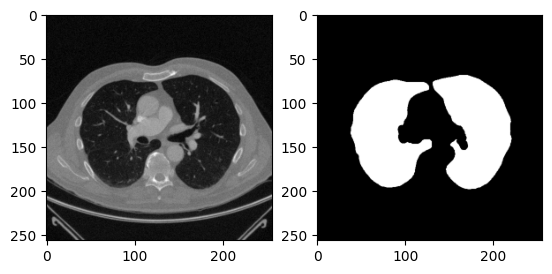

In [88]:
# show the image
fig, ax = plt.subplots(1, 2)
ax[0].imshow(x_data[0].squeeze(), cmap='gray')
ax[1].imshow(y_data[0].squeeze(), cmap='gray')

## Model

In [89]:
from sklearn.model_selection import train_test_split

In [111]:
# first, we split data in train and test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

### Pytorch

In [94]:
# Libraries
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F

In [95]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder: 3 blocks conv + pool incrementing the filters
        self.enc_conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.enc_conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.enc_conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Bottleneck
        self.bottleneck = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        # Decoder: three blocks upsample + conv reducing the filters
        self.up5 = nn.Upsample(scale_factor=2, mode='nearest')
        self.dec_conv5 = nn.Conv2d(256, 128, kernel_size=3, padding=1)

        self.up6 = nn.Upsample(scale_factor=2, mode='nearest')
        self.dec_conv6 = nn.Conv2d(128, 64, kernel_size=3, padding=1)

        self.up7 = nn.Upsample(scale_factor=2, mode='nearest')
        self.dec_conv7 = nn.Conv2d(64, 32, kernel_size=3, padding=1)

        # Output
        self.out_conv = nn.Conv2d(32, 1, kernel_size=1)

    def forward(self, x):
        # Encoder
        x = F.relu(self.enc_conv1(x))
        x = self.pool1(x)

        x = F.relu(self.enc_conv2(x))
        x = self.pool2(x)

        x = F.relu(self.enc_conv3(x))
        x = self.pool3(x)

        # Bottleneck
        x = F.relu(self.bottleneck(x))

        # Decoder
        x = self.up5(x)
        x = F.relu(self.dec_conv5(x))

        x = self.up6(x)
        x = F.relu(self.dec_conv6(x))

        x = self.up7(x)
        x = F.relu(self.dec_conv7(x))

        # Output
        x = torch.sigmoid(self.out_conv(x))
        return x

In [96]:
model = ConvAutoencoder()

In [97]:
# from train and test to torch
# note: I apply .permute to (batch_size, channels, height, width) instead of original (batch_size, height, width, channels) and then avoid the problem in -> RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[8, 256, 256, 1] to have 1 channels, but got 256 channels instead
x_train_tensor = torch.from_numpy(x_train).float().permute(0, 3, 1, 2) # [B, C, H, W]
y_train_tensor = torch.from_numpy(y_train).float().permute(0, 3, 1, 2) # [B, C, H, W]
x_test_tensor = torch.from_numpy(x_train).float().permute(0, 3, 1, 2) # [B, C, H, W]
y_test_tensor = torch.from_numpy(y_train).float().permute(0, 3, 1, 2) # [B, C, H, W]
# Dataset
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
# DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

In [98]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 2 # due to execution time issues

In [99]:
def get_loss(num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")
    return running_loss

In [100]:
# results
get_loss(num_epochs)

Epoch 1, Loss: 0.6018
Epoch 2, Loss: 0.4582


12.372202157974243

In [106]:
def dice_coeff(preds, targets, smooth=1e-6):
    # Binarize preds
    preds = (preds > 0.5).float()
    intersection = (preds * targets).sum()
    total = preds.sum() + targets.sum()
    return (2. * intersection + smooth) / (total + smooth)

def pixel_accuracy(preds, targets):
    preds = (preds > 0.5).float()
    correct = (preds == targets).float().sum()
    total = torch.numel(preds)
    return correct / total

def iou_score(preds, targets):
    preds = (preds > 0.5).float()
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    return (intersection + 1e-6) / (union + 1e-6)

In [107]:
# Evaluación
model.eval()
total_acc, total_iou, total_dice, num_batches = 0, 0, 0, 0

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        outputs = torch.sigmoid(outputs)  # si el modelo no tiene sigmoid al final

        acc = pixel_accuracy(outputs, masks)
        iou = iou_score(outputs, masks)
        dice = dice_coeff(outputs, masks)

        total_acc  += acc.item()
        total_iou  += iou.item()
        total_dice += dice.item()
        num_batches += 1

avg_acc  = total_acc  / num_batches
avg_iou  = total_iou  / num_batches
avg_dice = total_dice / num_batches

print(f"Pixel Accuracy: {avg_acc:.4f}")
print(f"IoU Score: {avg_iou:.4f}")
print(f"Dice Score: {avg_dice:.4f}")

Pixel Accuracy: 0.2173
IoU Score: 0.2351
Dice Score: 0.3799


### Keras (tf)

In [108]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.callbacks import ReduceLROnPlateau

In [ ]:
# Define input layer
inputs = Input(shape=(256, 256, 1))

# Encoder: three blocks conv + pool augmenting the filters
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

# Bottleneck layer
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)

# Decoder: 3 blocks upsampling + conv reducing the filters
up5 = UpSampling2D(size=(2, 2))(conv4)
conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(up5)

up6 = UpSampling2D(size=(2, 2))(conv5)
conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up6)

up7 = UpSampling2D(size=(2, 2))(conv6)
conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up7)

# Output layer
outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv7)

# Build model
model = Model(inputs=inputs, outputs=outputs)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 256, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 128, 128, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 256, 256, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 256, 256, 1)    │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 775,169 (2.96 MB)

 Trainable params: 775,169 (2.96 MB)

 Non-trainable params: 0 (0.00 B)

In [110]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, min_lr=1e-05)
# train model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=2, batch_size=32, callbacks=[reduce_lr])

Epoch 1/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.7134 - loss: 0.5632 - val_accuracy: 0.7441 - val_loss: 0.3757 - learning_rate: 0.0010
Epoch 2/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.7456 - loss: 0.3659 - val_accuracy: 0.7441 - val_loss: 0.3186 - learning_rate: 0.0010
